In [171]:
import numpy as np

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

import matplotlib as mpl
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

import pandas as pd
from pandas.plotting import register_matplotlib_converters

from datetime import datetime
from datetime import timedelta
from time import time

from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller



In [198]:
weather_his = pd.read_csv('weatherHistory.csv', parse_dates = [0])


weather_his.columns = ['Date', 'Summary', 'Precip Type', 'Temperature',
       'Apparent Temperature (C)', 'Humidity', 'Wind Speed (km/h)',
       'Wind Bearing (degrees)', 'Visibility (km)', 'Loud Cover',
       'Pressure (millibars)', 'Daily Summary']

weather_his['Date'] = pd.to_datetime(weather_his['Date'], utc=True).dt.tz_convert('Egypt')
weather_his.sort_values(by='Date', ascending = True, inplace = True)

weather_his.reset_index(drop = True, inplace = True)

weather_his.drop(columns = ['Summary', 'Precip Type', 'Apparent Temperature (C)', 'Wind Speed (km/h)',
       'Wind Bearing (degrees)', 'Visibility (km)', 'Loud Cover',
       'Pressure (millibars)', 'Daily Summary'], inplace = True)

weather_his.drop([96452], inplace = True)

weather_his.tail()

,Date,Temperature,Humidity
96447,2016-12-31 19:00:00+02:00,1.011111,0.85
96448,2016-12-31 20:00:00+02:00,0.488889,0.86
96449,2016-12-31 21:00:00+02:00,0.072222,0.88
96450,2016-12-31 22:00:00+02:00,-0.233333,0.89
96451,2016-12-31 23:00:00+02:00,-0.472222,0.91


In [199]:
#weather_his.info()

yearIndex = {}
for year in range(2006,2017):
    Ind = weather_his.index[weather_his.Date == pd.to_datetime(str(year)+'-01-01 01:00:00+02:00')]
    yearIndex[year] = list(Ind)[0]

def yearTime(i):
    currDate = weather_his.Date[i]
    #print(yearIndex[currDate.year])
    return weather_his.at[yearIndex[currDate.year], 'Time']
       
weather_his['Time'] = pd.Series([i for i in range(0,len(weather_his))])
print(weather_his.tail())

start = time()

TimeSubtractor = pd.Series([yearTime(i) for i in  range(0,len(weather_his))], name = 'TimeSubtractor')
weather_his['Time'] = weather_his['Time'] - TimeSubtractor
'''
print(np.array([[weather_his.Date[i],weather_his.Date[i].year, weather_his.Time[yearIndex[weather_his.Date[i].year]]] for i in  (0,3,100,50000,24*365*10+100)]))
print(np.array([yearIndex[i] for i in  (2006, 2011, 2016)]))
print(np.array([weather_his.at[yearIndex[i], 'Time'] for i in  (2006, 2011, 2016)]))
'''
end = time()
print('Model Fitting Time:', end - start)

weather_his.tail()

                           Date  Temperature  Humidity   Time
96447 2016-12-31 19:00:00+02:00     1.011111      0.85  96447
96448 2016-12-31 20:00:00+02:00     0.488889      0.86  96448
96449 2016-12-31 21:00:00+02:00     0.072222      0.88  96449
96450 2016-12-31 22:00:00+02:00    -0.233333      0.89  96450
96451 2016-12-31 23:00:00+02:00    -0.472222      0.91  96451
Model Fitting Time: 6.681777000427246


,Date,Temperature,Humidity,Time
96447,2016-12-31 19:00:00+02:00,1.011111,0.85,8778
96448,2016-12-31 20:00:00+02:00,0.488889,0.86,8779
96449,2016-12-31 21:00:00+02:00,0.072222,0.88,8780
96450,2016-12-31 22:00:00+02:00,-0.233333,0.89,8781
96451,2016-12-31 23:00:00+02:00,-0.472222,0.91,8782


In [211]:
start_date = pd.to_datetime('2012-01-01 00:00:00+02:00', utc = True).tz_convert('Egypt')
end_date = x = pd.to_datetime('2016-01-01 00:00:00+02:00', utc = True).tz_convert('Egypt')

start_row = list(np.where(weather_his['Date'] == start_date))[0][0]
end_row = list(np.where(weather_his['Date'] == end_date))[0][0]

train_data = weather_his.iloc[start_row:end_row]
test_data = weather_his.iloc[end_row: ]

train_data.head()

,Date,Temperature,Humidity,Time
52607,2012-01-01 00:00:00+02:00,-2.383333,0.92,-1
52608,2012-01-01 01:00:00+02:00,-2.894444,0.88,0
52609,2012-01-01 02:00:00+02:00,-2.755556,0.93,1
52610,2012-01-01 03:00:00+02:00,-3.472222,0.92,2
52611,2012-01-01 04:00:00+02:00,-3.544444,0.92,3


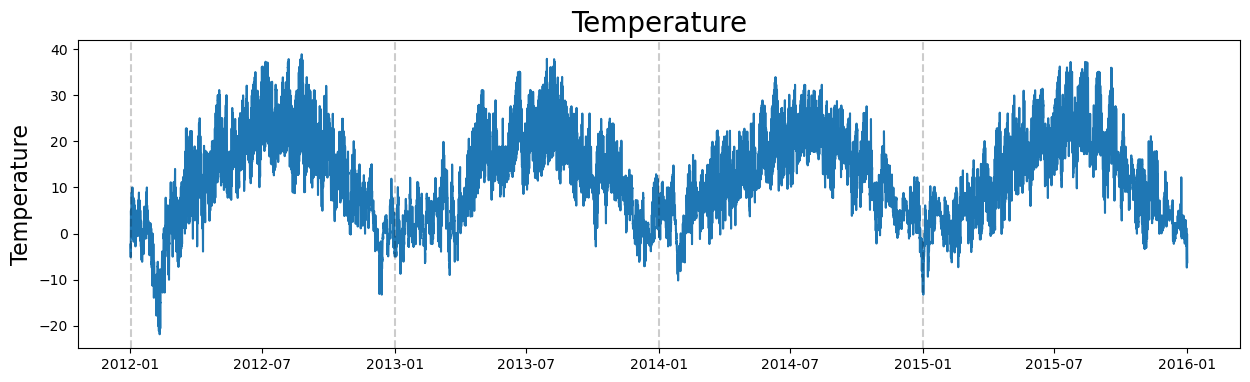

In [212]:
plt.figure(figsize=(15,4))
plt.plot(train_data.Date, train_data.Temperature)
plt.title('Temperature', fontsize=20)
plt.ylabel('Temperature', fontsize=16)
for year in range(start_date.year, end_date.year):
    plt.axvline(pd.to_datetime(str(year)+'-01-01'), color='k', linestyle='--', alpha=0.2)

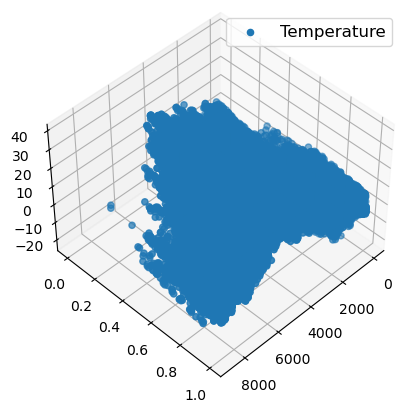

In [213]:
mpl.rcParams['legend.fontsize'] = 12

fig = plt.figure(200)
ax = fig.add_subplot(projection = '3d')

ax.scatter(train_data.Time, train_data.Humidity, train_data.Temperature, label='Temperature')
ax.legend()
ax.view_init(45,45)

plt.show()

In [224]:
X = pd.merge(train_data.Time, train_data.Humidity, right_index = True, left_index = True)
y = train_data.Temperature

Xtest = pd.merge(test_data.Time, test_data.Humidity, right_index = True, left_index = True)
ytest = test_data.Temperature


#X are the covariate and y is the temperature variable

In [225]:
# Create an instance of the LinearRegression class
reg = LinearRegression()
 
# Fit the model to the data
reg.fit(X, y)
 
# Print the coefficients of the model
print(reg.coef_)
print(reg.intercept_)

[ 8.44392321e-04 -3.02542715e+01]
30.61259424249392


In [226]:
ypred = reg.predict(Xtest)

print()
print(mean_squared_error(ytest,ypred))
print(r2_score(ytest,ypred))


47.06263793674376
0.42305554000107504


In [227]:
#messing with covariance

cov = np.cov(train_data.Time, train_data.Humidity)
correlation = cov[1][0]/np.sqrt(cov[0][0] * cov[1][1])

print(correlation)

0.09745575271519541


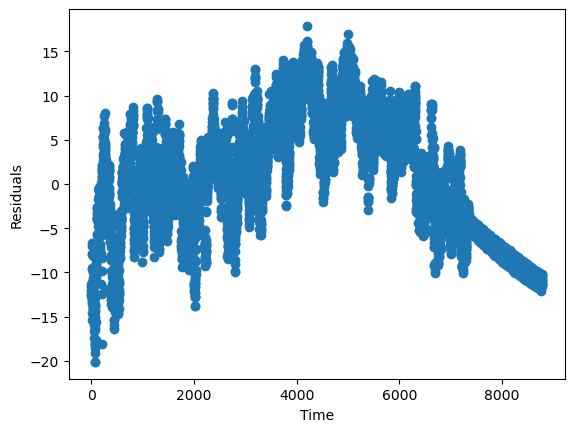

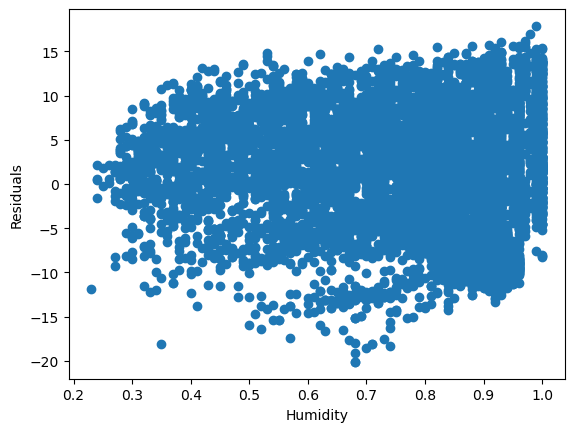

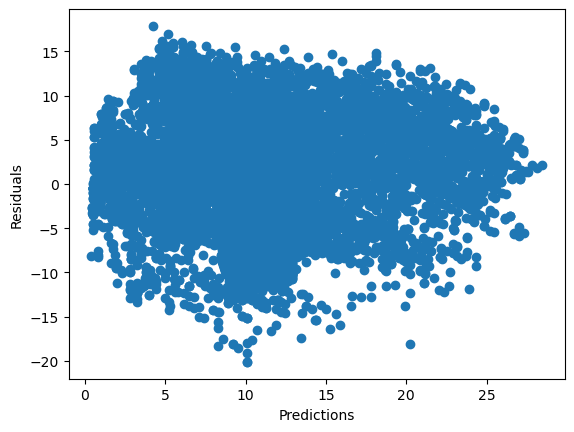

In [235]:
#plotting residuals

plt.scatter(Xtest.Time,ytest-ypred)
plt.xlabel('Time')
plt.ylabel('Residuals')
plt.show()

plt.scatter(Xtest.Humidity,ytest-ypred)
plt.xlabel('Humidity')
plt.ylabel('Residuals')
plt.show()

plt.scatter(ypred,ytest-ypred)
plt.xlabel('Predictions')
plt.ylabel('Residuals')
plt.show()


In [228]:
#doing linear regression from scratch 
#remember to put the 1 in the first column of design matrix to get the intercept term 

DesignMatrix = [[1, train_data.at[i,'Time'], train_data.at[i,'Humidity']] for i in range(52607,52607+len(train_data))]
DesignMatrix = np.array(DesignMatrix)
DesignMatrixTranspose = np.transpose(DesignMatrix)

TemperatureArray =  np.array([train_data.at[i,'Temperature'] for i in range(52607,52607+len(train_data))])

BetaHat = np.linalg.inv(np.matmul(DesignMatrixTranspose, DesignMatrix))
BetaHat = np.matmul(BetaHat,DesignMatrixTranspose)
BetaHat = np.matmul(BetaHat,TemperatureArray)

print(BetaHat)

[ 3.06125942e+01  8.44392321e-04 -3.02542715e+01]
